In [1]:
# make sure installation has succeeded
import tempo_embeddings

In [2]:
%load_ext autoreload

In [3]:
try:
    import google.colab

    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

## Load Collection from Database

In [4]:
%autoreload now

from pathlib import Path
from tqdm import tqdm
from tempo_embeddings.text.corpus import Corpus

/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from tempo_embeddings.embeddings.vector_database import ChromaDatabaseManager

# Here we load only the ANP collection because metadata field names diverge across datasets
db = ChromaDatabaseManager(db_path="testing_db", batch_size=24)
db.connect()

anp_sg_collection = db.get_existing_collection("anp_sg_corpus")

Retrieved existing collection 'anp_sg_corpus'


## Create Sub-Collections per Time Bucket

In [6]:
FILTER_TERMS = ["duurzaam"]

passages_1983 = db.get_passages(anp_sg_collection, filter_words=FILTER_TERMS, where_obj={'year':'1983'}, include_embeddings=True)
passages_1984 = db.get_passages(anp_sg_collection, filter_words=FILTER_TERMS, where_obj={'year':'1984'}, include_embeddings=True)
passages_2017 = db.get_passages(anp_sg_collection, filter_words=FILTER_TERMS, where_obj={'year':'2017'}, include_embeddings=True)
print(len(passages_1983), len(passages_1984), len(passages_2017))

32 22 631


## Choose Year and Plot Passages

In [7]:
import statistics
def get_corpus_with_neighborhoods(collection, passages, k_neighbors):
    all_neighbors = []
    all_distances = []
    for p in passages:
        neighbors = db.query_vector_neighbors(collection, vector=p.embedding, k_neighbors=k_neighbors)
        for passage, distance in neighbors:
            all_neighbors.append(passage)
            all_distances.append(distance)
    print(f"Total Datapoints in the neighborhoods = {len(all_neighbors)}")
    print(f"Distance Info: Max = {max(all_distances)} | Min = {min(all_distances)} | Average = {statistics.mean(all_distances)}")
    # Join original passages + new found neighbors
    all_passages = passages+all_neighbors
    corpus = Corpus(all_passages)
    corpus.embeddings = db.compress_embeddings(all_passages)
    print(corpus.embeddings.shape)
    return corpus

In [8]:
corpus_1980s = get_corpus_with_neighborhoods(anp_sg_collection, passages_1983+passages_1984, k_neighbors=10)
corpus_2017 = get_corpus_with_neighborhoods(anp_sg_collection, passages_2017, k_neighbors=3)

Total Datapoints in the neighborhoods = 540
Distance Info: Max = 0.5163577795028687 | Min = -2.0265579223632812e-06 | Average = 0.3184728475632491
UMAP( verbose=True)
Thu Feb 15 16:31:42 2024 Construct fuzzy simplicial set
Thu Feb 15 16:31:42 2024 Finding Nearest Neighbors
Thu Feb 15 16:31:43 2024 Finished Nearest Neighbor Search
Thu Feb 15 16:31:44 2024 Construct embedding


Epochs completed:  89%| ████████▉  447/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:01]


	completed  450  /  500 epochs
Thu Feb 15 16:31:45 2024 Finished embedding
(594, 2)
Total Datapoints in the neighborhoods = 1893
Distance Info: Max = 0.5540946125984192 | Min = -1.6689300537109375e-06 | Average = 0.24475692843106206
UMAP( verbose=True)
Thu Feb 15 16:31:47 2024 Construct fuzzy simplicial set
Thu Feb 15 16:31:49 2024 Finding Nearest Neighbors
Thu Feb 15 16:31:49 2024 Finished Nearest Neighbor Search
Thu Feb 15 16:31:49 2024 Construct embedding


Epochs completed:  33%| ███▎       164/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs


Epochs completed:  63%| ██████▎    314/500 [00:01]

	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs


Epochs completed:  91%| █████████▏ 457/500 [00:01]

	completed  400  /  500 epochs
	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:01]

Thu Feb 15 16:31:51 2024 Finished embedding
(2524, 2)


## Read Stopwords

In [9]:
stopwords_file = Path("stopwords-filter-nl.txt")

with open(stopwords_file.absolute(), "rt") as f:
    stopwords = set(f.read().splitlines())

stopwords.update(
    {
        "wij",
        "we",
        "moeten",
        "heer",
        "mevrouw",
        "minister",
        "voorzitter",
        "gaat",
        "wel",
        "den",
    }
)

## Cluster Separately

In [10]:
%autoreload now

# Arguments: min_cluster_size=10, cluster_selection_epsilon=0.1, ...
# See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html for full list

# e.g. min_samples=10, cluster_selection_epsilon=0.2, cluster_selection_method="leaf"

clusters_1980s = corpus_1980s.cluster(min_cluster_size=10, cluster_selection_epsilon=0.1)
print(clusters_1980s)

clusters_2017 = corpus_2017.cluster(min_cluster_size=10, cluster_selection_epsilon=0.1)
print(clusters_2017)

[Subcorpus(2, [0, 8, 9, 21, 54, 55, 56, 57, 58, 59]), Subcorpus(8, [1, 4, 5, 64, 65, 66, 67, 68, 69, 70]), Subcorpus(15, [2, 7, 60, 74, 75, 79, 80, 81, 82, 83]), Subcorpus(12, [3, 6, 30, 84, 85, 86, 87, 88, 89, 90]), Subcorpus(9, [10, 154, 155, 156, 157, 158, 159, 160, 161, 162]), Subcorpus(3, [11, 18, 19, 164, 165, 166, 167, 168, 169, 170]), Subcorpus(5, [12, 13, 174, 175, 176, 177, 178, 180, 182, 183]), Subcorpus(-1, [14, 15, 22, 29, 61, 141, 142, 194, 200, 204]), Subcorpus(6, [16, 32, 33, 35, 37, 39, 44, 49, 50, 51]), Subcorpus(7, [17, 20, 23, 198, 224, 225, 226, 227, 228, 229]), Subcorpus(10, [24, 28, 139, 143, 181, 202, 294, 295, 296, 300]), Subcorpus(17, [25, 304, 306, 307, 308, 309, 310, 311, 312, 313]), Subcorpus(18, [26, 31, 299, 314, 315, 316, 317, 319, 320, 321]), Subcorpus(11, [27, 201, 298, 324, 325, 327, 328, 330, 331, 333]), Subcorpus(0, [34, 394, 395, 396, 397, 398, 403, 438, 439, 440]), Subcorpus(14, [36, 53, 76, 78, 127, 128, 129, 131, 133, 213]), Subcorpus(1, [38, 42

In [11]:
for cluster in clusters_1980s:
    cluster.set_topic_label(exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5)
    print(cluster)

for cluster in clusters_2017:
    cluster.set_topic_label(exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5)
    print(cluster)

/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Subcorpus('verbetering; opbouwen; inflatie; daarbij; eigen', [0, 8, 9, 21, 54, 55, 56, 57, 58, 59])
Subcorpus('antillen; nederlandse; aruba; antilliaanse; aparte', [1, 4, 5, 64, 65, 66, 67, 68, 69, 70])
Subcorpus('huidige; economische; duurzaamheid; aldus; lennep', [2, 7, 60, 74, 75, 79, 80, 81, 82, 83])
Subcorpus('bouw; toekomst; enquête; bouwvergunningen; nabije', [3, 6, 30, 84, 85, 86, 87, 88, 89, 90])
Subcorpus('fijenoord; wilton; scheeps; verantwoord; bedrijfseconomisch', [10, 154, 155, 156, 157, 158, 159, 160, 161, 162])
Subcorpus('toeslag; gulden; aangepast; verhoogd; rijkswegen', [11, 18, 19, 164, 165, 166, 167, 168, 169, 170])
Subcorpus('odder; westen; dalende; weinig; kansen', [12, 13, 174, 175, 176, 177, 178, 180, 182, 183])
Subcorpus('Outliers', [14, 15, 22, 29, 61, 141, 142, 194, 200, 204])
Subcorpus('beiroet; libanese; bestand; bron; libanon', [16, 32, 33, 35, 37, 39, 44, 49, 50, 51])
Subcorpus('instellingen; ontwikkelingslanden; afhankelijk; wereldeconomi; vereist', [17,

In [12]:
with open("clusters_1908s.txt", "wt") as f:
    for cluster in clusters_1980s:
        print(
            ", ".join(
                cluster.top_words(
                    exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5
                )
            ),
            file=f,
        )

with open("clusters_2017.txt", "wt") as f:
    for cluster in clusters_2017:
        print(
            ", ".join(
                cluster.top_words(
                    exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5
                )
            ),
            file=f,
        )

# Visualize 1980s Embeddings

<Axes: xlabel='x', ylabel='y'>

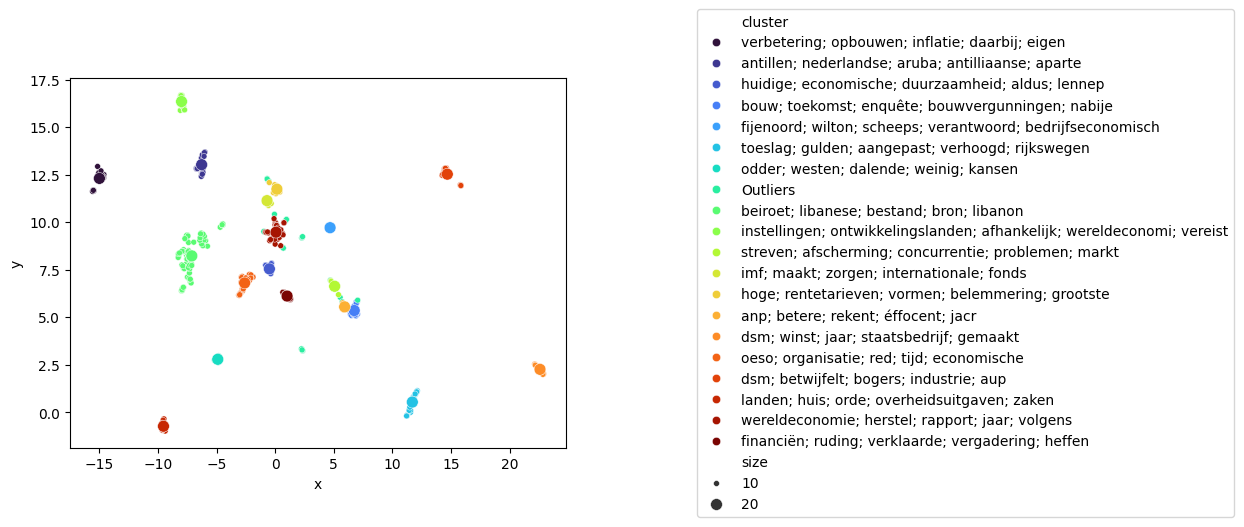

In [13]:
%autoreload now

from tempo_embeddings.visualization.clusters import ClusterVisualizer

clusters = clusters_1980s
corpus = corpus_1980s

visualizer = ClusterVisualizer(*clusters)
visualizer.visualize()

In [14]:
import os
from bokeh.io import output_notebook
from bokeh.plotting import show
from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer


output_notebook()

visualizer = BokehInteractiveVisualizer(
    *clusters, metadata_fields=corpus.metadata_fields(), width=2000, height=1000
)

os.environ[
    "BOKEH_ALLOW_WS_ORIGIN"
] = "*"

show(visualizer.create_document)

Loading BokehJS ...

## Visualize 2017 Embeddings

In [17]:
%autoreload now

clusters = clusters_2017
corpus = corpus_2017

# visualizer = ClusterVisualizer(*clusters)
# visualizer.visualize()

In [16]:
output_notebook()

visualizer = BokehInteractiveVisualizer(
    *clusters, metadata_fields=corpus.metadata_fields(), width=2000, height=1000
)

os.environ[
    "BOKEH_ALLOW_WS_ORIGIN"
] = "*"

show(visualizer.create_document)

Loading BokehJS ...